# Dynamic Averaging Results: Logistic Regression

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from dyn_fed.utils.report_utils import generate_all_pivots, generate_packet_size_pivots
from dyn_fed.viz.report import plot_results, plot_pkt_size, plot_model_performance

rc('text', usetex=True)

In [3]:
project_dir = Path().resolve().parents[1]
project_dir

PosixPath('/Users/sashlinreddy/repos/masters/dyn-fed')

In [4]:
masters_dir = Path().resolve().parents[2]
masters_dir

PosixPath('/Users/sashlinreddy/repos/masters')

In [5]:
thesis_dir = (masters_dir/"fed-learn-thesis").resolve()
thesis_dir

PosixPath('/Users/sashlinreddy/repos/masters/fed-learn-thesis')

Join results

In [6]:
df1 = pd.read_csv(project_dir/"data/20200427-results.csv")
df2 = pd.read_csv(project_dir/"data/20200428-results.csv")
df3 = pd.read_csv(project_dir/"data/20200509-results.csv")
# df4 = pd.read_csv(project_dir/"data/20200614-results.csv")
# df5 = pd.read_csv(project_dir/"data/20200615-results.csv")
# df6 = pd.read_csv(project_dir/"data/20200616-results.csv")
results = pd.concat([df1, df2, df3]).reset_index(drop=True)

In [7]:
# df4[df4.error == 1].sort_values(['dataset', 'optimizer', 'n_clients', 'noniid', 'unbalanced', 'epochs', 'delta_threshold'])

# Performance analysis

In [8]:
metrics = ['time', 'test_loss', 'test_acc', 'gen_gap', 'pkt_size', 'avg_comm_rate']

In [9]:
model = 'LR'

## MNIST - SGD

In [10]:
dataset = 'MNIST'
optimizer = 'SGD'

In [11]:
results = results.query('n_clients < 64')

In [12]:
results.shape

(2088, 21)

In [13]:
results.head()

,jobid,dataset,model_type,optimizer,n_clients,agg_mode,interval,comm_mode,noniid,unbalanced,...,epochs,delta_threshold,error,time,train_acc,test_acc,train_loss,test_loss,pkt_size,comm_rounds
0,60576,fashion-mnist,logistic,adam,32,1,1,0,0,1,...,100,NaN,0,130.226681,82.9133,82.11,1.5907,1.5992,92.919,3100.0
1,60577,mnist,logistic,sgd,24,1,20,0,0,0,...,100,NaN,0,20.272419,83.5967,84.42,1.7588,1.7534,3.447,115.0
2,60578,mnist,logistic,sgd,8,1,20,0,1,1,...,100,NaN,0,41.749354,67.8100,68.67,1.5134,1.8902,1.049,35.0
3,60579,fashion-mnist,cnn1,adam,24,1,1,1,1,1,...,50,NaN,0,342.623015,75.6150,74.52,1.5820,1.7204,1831.963,692.0
4,60580,fashion-mnist,cnn1,adam,24,1,1,2,1,0,...,50,NaN,1,NaN,12.1133,12.21,2.3042,2.3043,NaN,NaN


In [14]:
results.loc[:, "avg_comm_rate"] = results["comm_rounds"] / (results["n_clients"] - 1)

In [15]:
results.loc[:, "gen_gap"] = (results["test_loss"] - results["train_loss"]) / ((results["test_loss"] + results["train_loss"]))

In [16]:
results.loc[:, "delta_threshold"] = results.delta_threshold.fillna(0.0)

In [17]:
error_query = 'error == 1'
results = results.drop(results.query(error_query).index).reset_index(drop=True)

In [18]:
results.shape

(2074, 23)

In [19]:
results.loc[:, "n_clients"] = results["n_clients"] - 1

In [20]:
drop_query = "(delta_threshold <= 0.0 or delta_threshold > 2.0) and comm_mode == 3"
adam_results = results.copy()
results = results.drop(results.query(drop_query).index).reset_index(drop=True)

In [21]:
adam_results.shape

(2074, 23)

In [22]:
lr_mnist = results.query(
    "dataset == 'mnist' and model_type=='logistic' and n_clients < 63"
    " and optimizer == 'sgd'"
)
lr_fmnist = results.query(
    "dataset == 'fashion-mnist' and model_type=='logistic' and n_clients < 63"
    " and optimizer == 'sgd'"
)

In [23]:
mnist_res, mnist_q = generate_all_pivots(lr_mnist, metrics=metrics)

### Wall time

In [24]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']

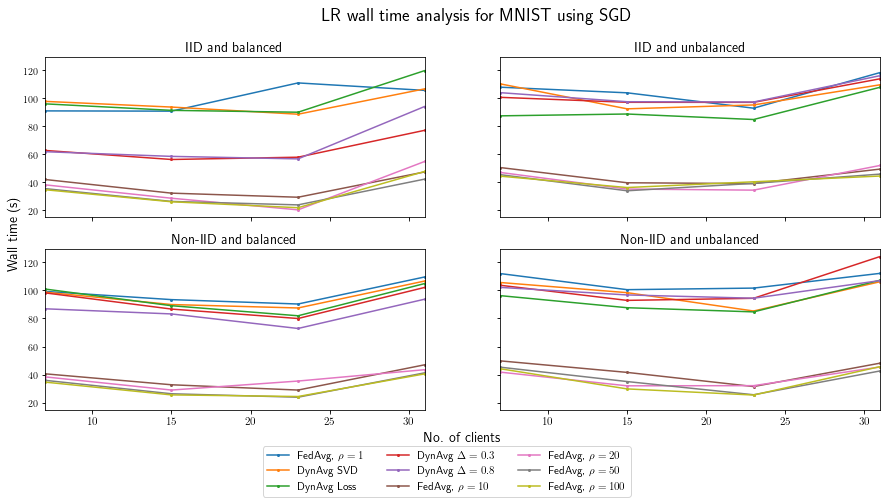

In [25]:
plot_results(
    mnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for {dataset} using {optimizer}',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/lr-mnist-sgd-time.png', dpi=500, format='png', bbox_inches='tight')

### Accuracy

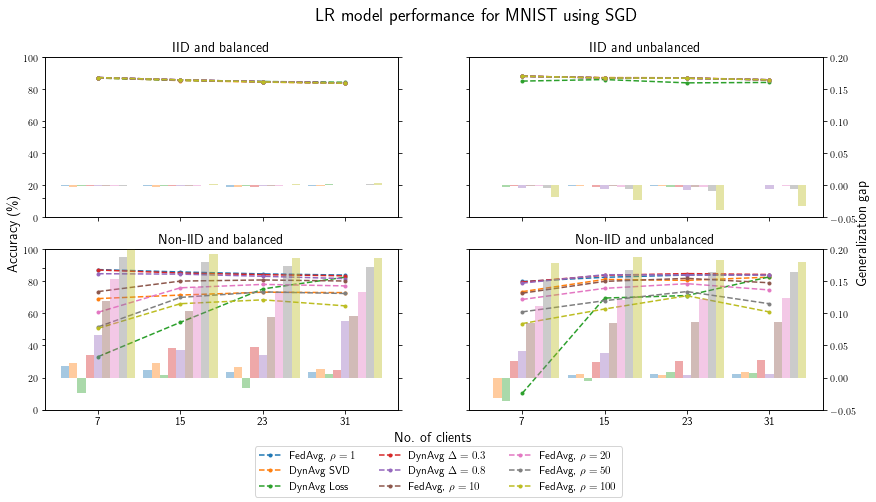

In [27]:
plot_model_performance(
    mnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for {dataset} using {optimizer}'
)
# plt.tight_layout()
plt.savefig(
    thesis_dir/f'figures/{model.lower()}-mnist-{optimizer.lower()}-mp.png',
    dpi=500,
    format='png',
#     pad_inches=0,
    bbox_inches='tight'
)

In [28]:
# plot_model_performance(
#     mnist_res,
#     metric1='avg_comm_rate',
#     metric2='pkt_size',
#     titles=titles,
#     xlabel='No. of clients',
#     ylabel1='Average communicate rate',
#     ylabel2='Accumulated packet size',
#     suptitle=f'{model} communication analysis for {dataset} using {optimizer}',
#     ylim=None,
#     ylim2=None,
#     bar_alpha=0.6
# )

In [29]:
# plot_results(
#     mnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for MNIST using SGD',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/lr-mnist-sgd-acc.png', dpi=500, format='png')

### Generalization gap

In [30]:
# plot_results(
#     mnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for MNIST using SGD',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/lr-mnist-sgd-gen-gap.png', dpi=500, format='png')

### Packet size

In [31]:
# mnist_res[1]['test_acc']['mean'].plot(
#     kind='line',
#     #width=0.85,
#     rot=0,
#     xerr=mnist_res[0]['test_acc']['stderr'],
# #     fmt=
#     # error_kw=dict(alpha=0.4)
# #     error_kw=dict(ecolor='black',elinewidth=1)
# )
# plt.legend([])
# for i in range(len(mnist_res[1]['test_acc']['mean'].columns)):
#     plt.fill_between(
#         mnist_res[1]['test_acc']['mean'].index,
#         mnist_res[1]['test_acc']['mean'].iloc[:, i] - (mnist_res[1]['test_acc']['stderr'].iloc[:, i] * 10),
#         mnist_res[1]['test_acc']['mean'].iloc[:, i] + (mnist_res[1]['test_acc']['stderr'].iloc[:, i] * 10),
#         color='gray',
#         alpha=0.2
#     )

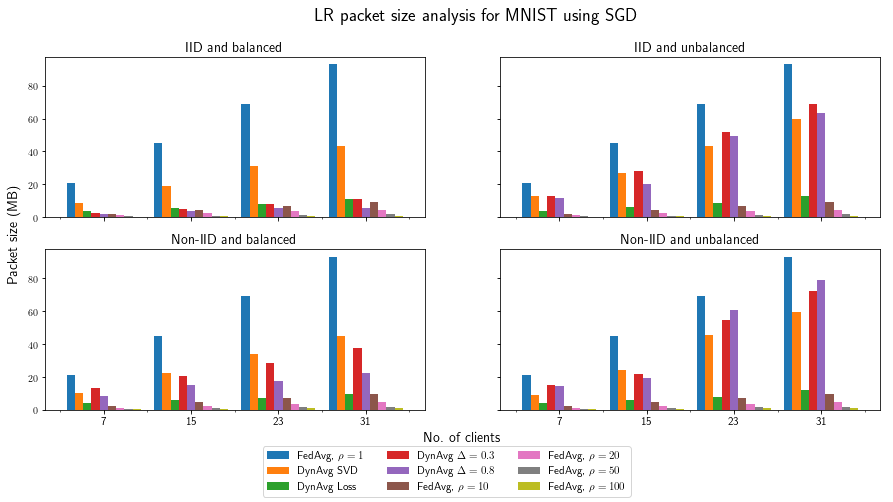

In [32]:
plot_results(
    mnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/lr-mnist-sgd-pkt.png', dpi=500, format='png', bbox_inches='tight')

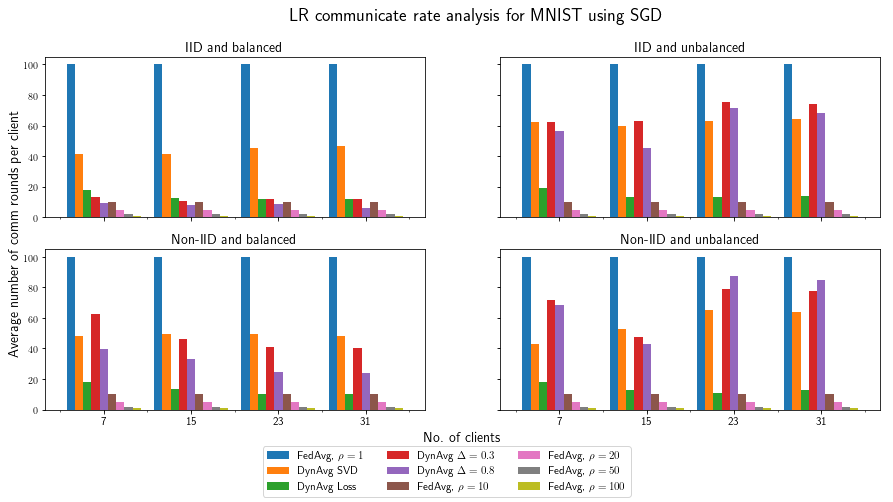

In [33]:
plot_results(
    mnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/lr-mnist-sgd-cr.png', dpi=500, format='png', bbox_inches='tight')

## Fashion-MNIST - SGD

In [34]:
dataset = 'Fashion-MNIST'

In [35]:
fmnist_res, fmnist_q = generate_all_pivots(lr_fmnist, metrics=metrics)

### Wall time

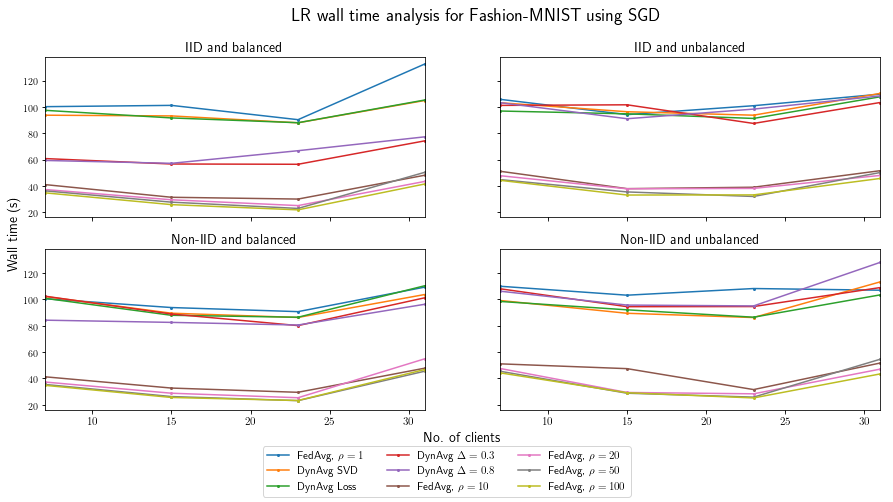

In [36]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    fmnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for Fashion-MNIST using SGD',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/lr-fmnist-sgd-time.png', dpi=500, format='png', bbox_inches='tight')

### Accuracy

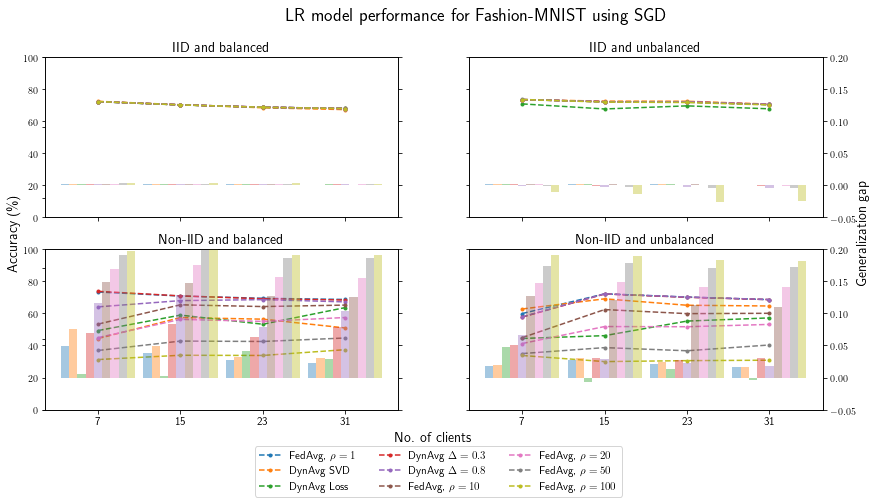

In [37]:
plot_model_performance(
    fmnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for {dataset} using {optimizer}'
)
plt.savefig(
    thesis_dir/f'figures/{model.lower()}-fmnist-{optimizer.lower()}-mp.png',
    dpi=500,
    format='png',
    bbox_inches='tight'
)

In [38]:
# plot_results(
#     fmnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for Fashion-MNIST using SGD',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/lr-fmnist-sgd-acc.png', dpi=500, format='png')

### Generalization gap

In [39]:
# plot_results(
#     fmnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for Fashion-MNIST using SGD',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/lr-fmnist-sgd-gen-gap.png', dpi=500, format='png')

### Packet size

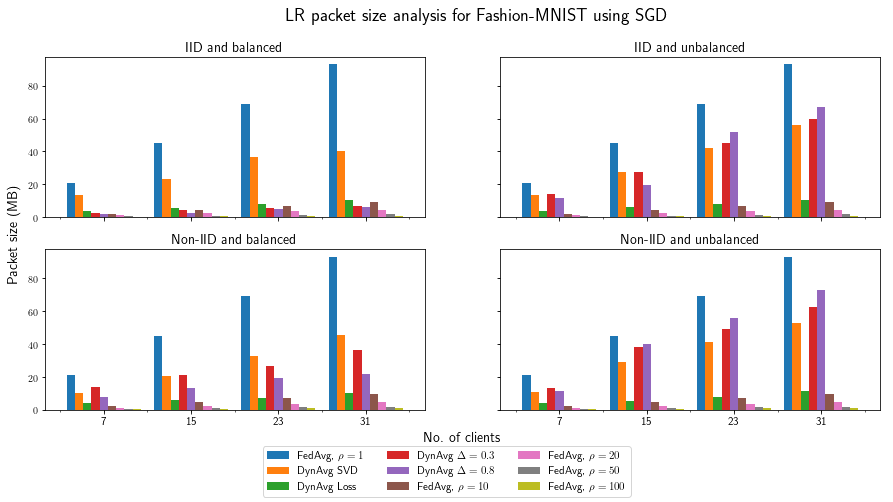

In [40]:
plot_results(
    fmnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for Fashion-MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/lr-fmnist-sgd-pkt.png', dpi=500, format='png', bbox_inches='tight')

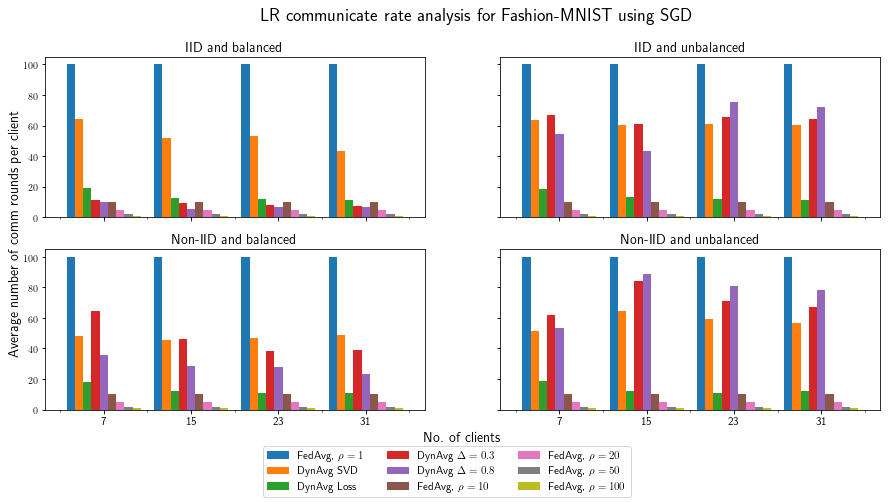

In [41]:
plot_results(
    fmnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for Fashion-MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/lr-fmnist-sgd-cr.png', dpi=500, format='png', bbox_inches='tight')

## MNIST - Adam

In [42]:
dataset = 'MNIST'
optimizer = 'Adam'

In [43]:
drop_query = '(delta_threshold == 0.0 or delta_threshold < 4.0) and comm_mode == 3'
adam_results = adam_results.drop(adam_results.query(drop_query).index).reset_index(drop=True)

In [44]:
adam_results.shape

(1278, 23)

In [47]:
lr_mnist = adam_results.query(
    "dataset == 'mnist' and model_type=='logistic' and n_clients < 63"
    " and optimizer == 'adam'"
)
lr_fmnist = adam_results.query(
    "dataset == 'fashion-mnist' and model_type=='logistic' and n_clients < 63"
    " and optimizer == 'adam'"
)

In [48]:
mnist_res, mnist_q = generate_all_pivots(lr_mnist, metrics=metrics)

### Wall time

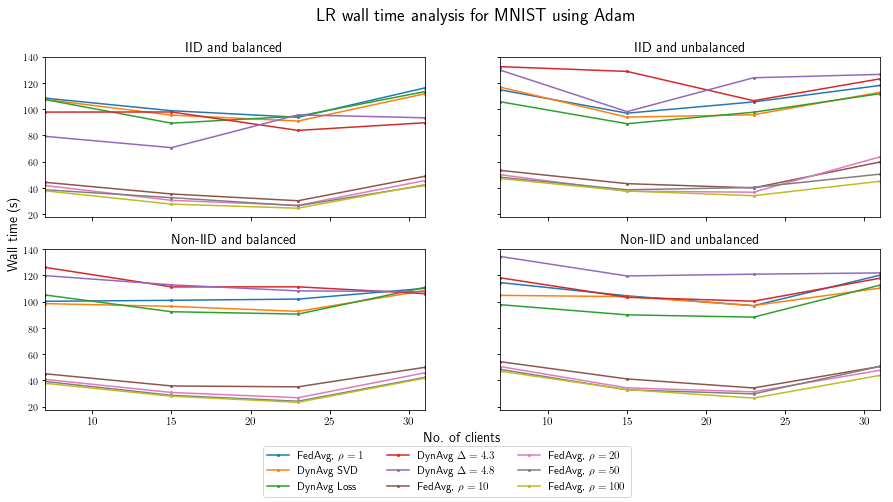

In [49]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    mnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/lr-mnist-adam-time.png', dpi=500, format='png', bbox_inches='tight')

### Accuracy

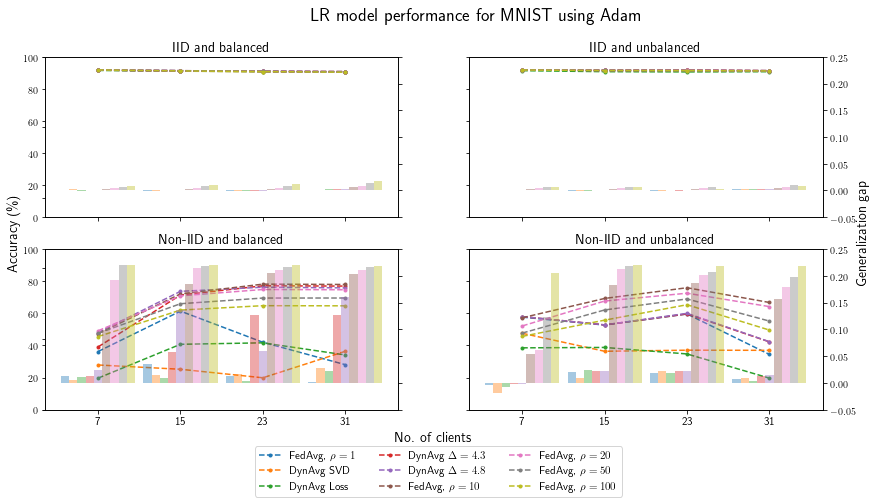

In [50]:
plot_model_performance(
    mnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for {dataset} using {optimizer}',
    ylim2=(-0.05, 0.25)
)
plt.savefig(
    thesis_dir/f'figures/{model.lower()}-mnist-{optimizer.lower()}-mp.png',
    dpi=500,
    format='png',
    bbox_inches='tight'
)

In [51]:
# plot_results(
#     mnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for MNIST using Adam',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/lr-mnist-adam-acc.png', dpi=500, format='png')

### Generalization gap

In [52]:
# plot_results(
#     mnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for MNIST using Adam',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/lr-mnist-adam-gen-gap.png', dpi=500, format='png')

### Packet size

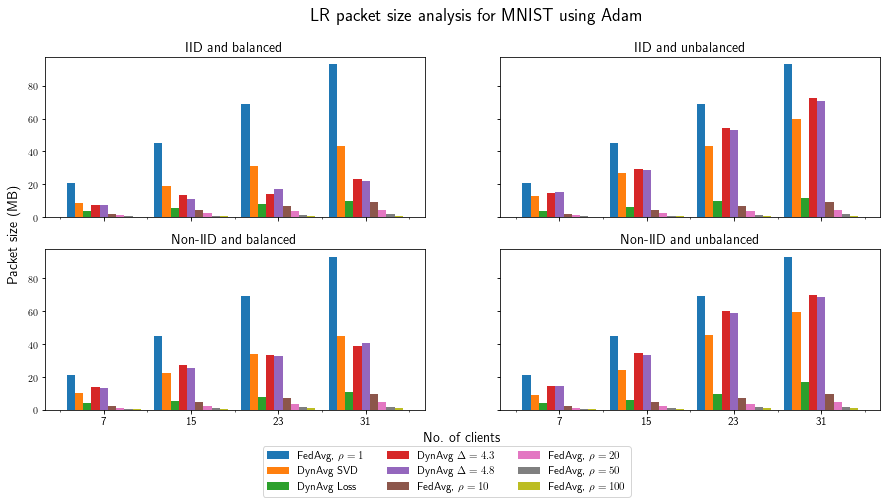

In [53]:
plot_results(
    mnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/lr-mnist-adam-pkt.png', dpi=500, format='png', bbox_inches='tight')

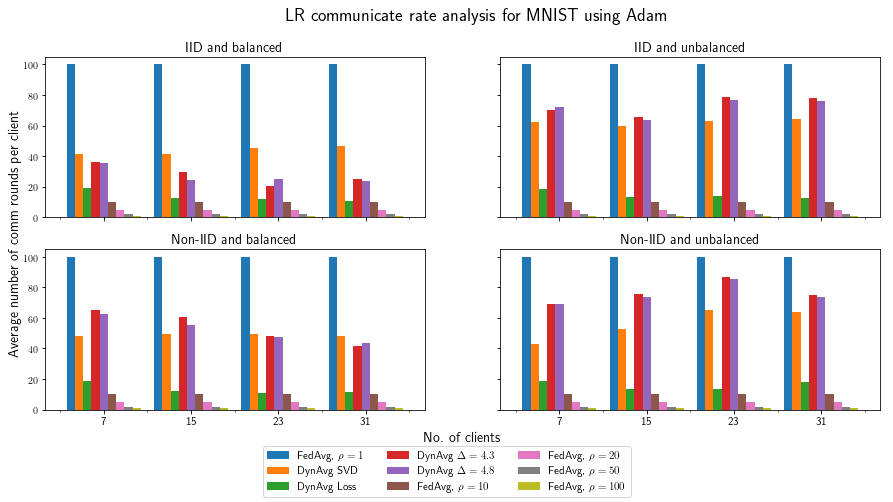

In [54]:
plot_results(
    mnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/lr-mnist-adam-cr.png', dpi=500, format='png', bbox_inches='tight')

## Fashion-MNIST - Adam

In [55]:
dataset = 'Fashion-MNIST'
optimizer = 'Adam'

In [56]:
fmnist_res, fmnist_q = generate_all_pivots(lr_fmnist, metrics=metrics)

### Wall time

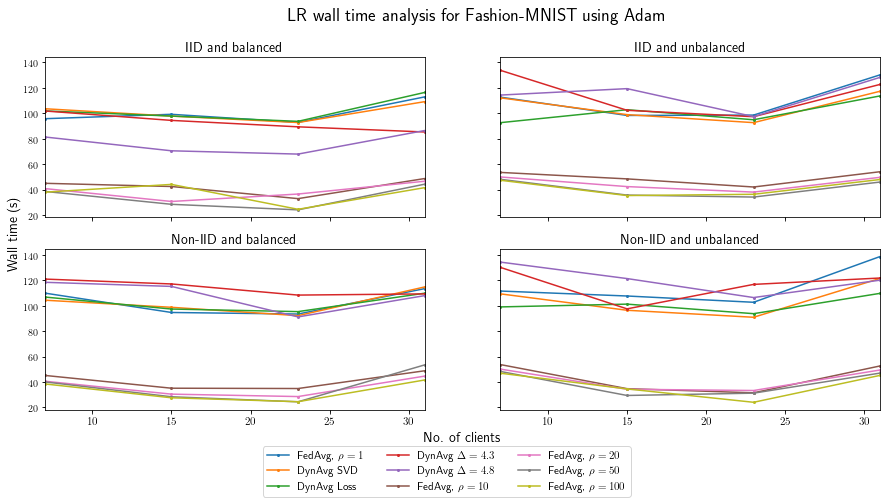

In [57]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    fmnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for Fashion-MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/lr-fmnist-adam-time.png', dpi=500, format='png', bbox_inches='tight')

### Accuracy

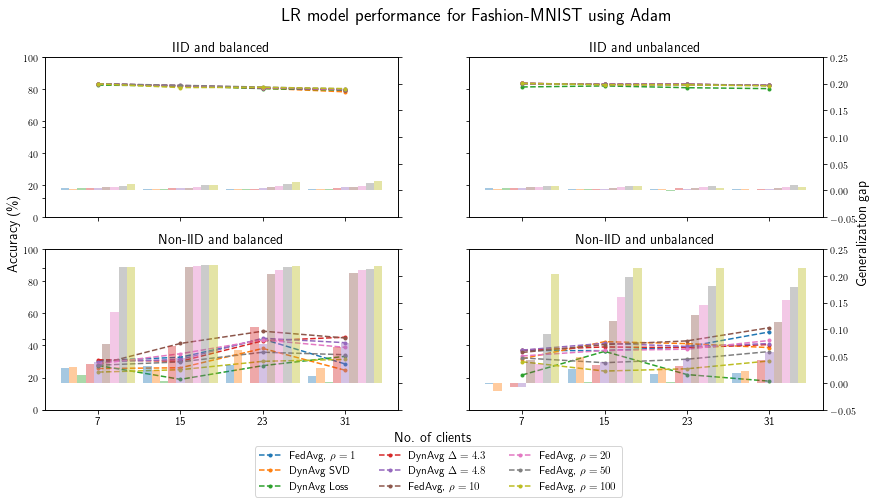

In [58]:
plot_model_performance(
    fmnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for {dataset} using {optimizer}',
    ylim2=(-0.05, 0.25)
)
plt.savefig(
    thesis_dir/f'figures/{model.lower()}-fmnist-{optimizer.lower()}-mp.png',
    dpi=500,
    format='png',
    bbox_inches='tight'
)

In [59]:
# plot_results(
#     fmnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for Fashion-MNIST using Adam',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/lr-fmnist-adam-acc.png', dpi=500, format='png')

### Generalization gap

In [60]:
# plot_results(
#     fmnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for Fashion-MNIST using Adam',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/lr-fmnist-adam-gen-gap.png', dpi=500, format='png')

### Packet size

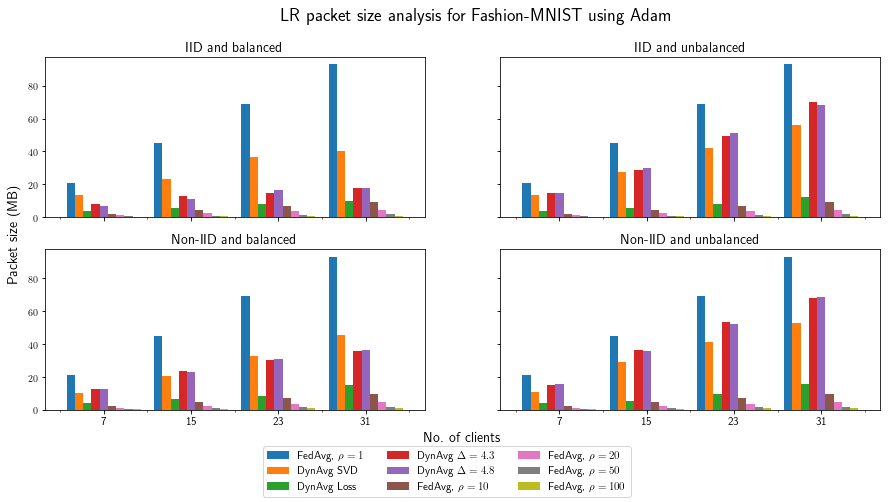

In [61]:
plot_results(
    fmnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for Fashion-MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/lr-fmnist-adam-pkt.png', dpi=500, format='png', bbox_inches='tight')

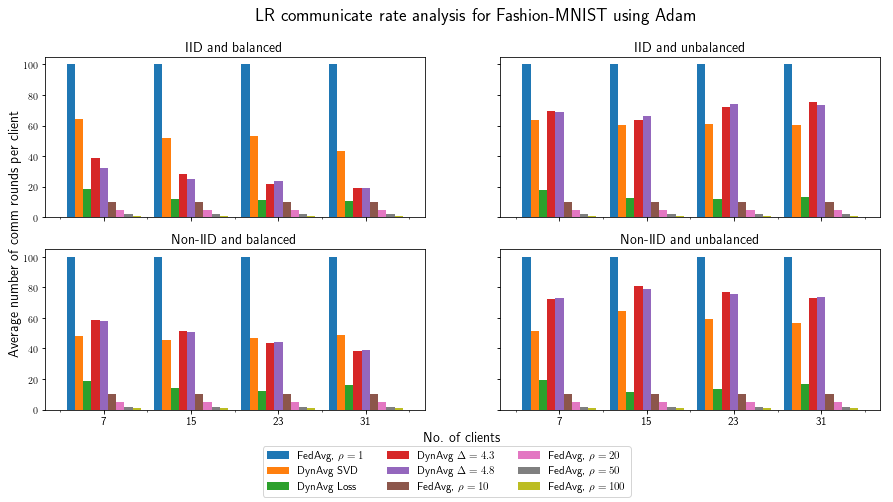

In [62]:
plot_results(
    fmnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for Fashion-MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/lr-fmnist-adam-cr.png', dpi=500, format='png', bbox_inches='tight')

# Other

In [4]:
mnist_fed = pd.read_csv("../data/output/mnist-pkt-size.csv")
# mnist_avg = pd.read_csv("../data/output/mnist-avg.csv")

In [5]:
mnist_fed.head()

,N_WORKERS,COMM_PERIOD,AGG_MODE,COMM_MODE,NONIID,UNBALANCED,TIME,ACCURACY,PKT_SIZE
0,16,1,0,0,0,0,53.428523,90.52,44.968
1,16,1,0,0,0,1,56.661802,90.55,44.968
2,16,1,0,0,1,0,62.546713,87.87,44.968
3,16,1,0,0,1,1,80.243772,79.60,44.968
4,16,1,0,1,0,0,48.823966,90.28,18.707


In [6]:
# mnist_avg.head()

#### IID and balanced

##### Time

In [7]:
ib_query = 'NONIID == 0 and UNBALANCED == 0'
t_ib_merged = performance_pivot(mnist_fed, ib_query, 'TIME', columns=columns, xlabel=xlabel)
t_ib_merged

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,80.815287,81.006431,80.554017,67.467648,67.877507,66.717027,67.274951
16,57.127120,50.133118,50.448137,40.679561,40.095585,38.484602,38.897185
32,46.617638,39.494684,45.936536,26.629159,24.917492,22.994617,23.790363
64,39.708639,39.152623,46.155075,17.988827,16.177416,16.039742,14.793734


##### Accuracy

In [8]:
acc_ib_merged = performance_pivot(mnist_fed, ib_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_ib_merged

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,91.26,91.00,90.79,91.26,91.28,91.28,91.30
16,90.52,90.27,90.24,90.57,90.52,90.47,90.41
32,89.58,89.58,89.65,89.56,89.53,89.49,89.39
64,88.44,88.41,88.56,88.43,88.40,88.26,88.02


In [9]:
# ax = acc_ib_merged_piv.plot(figsize=(12, 8))
# ax.set_ylabel('Wall time (s)', fontdict=dict(fontsize=12))
# ax.set_xlabel('No. of workers', fontdict=dict(fontsize=12))

#### Non-IID and Balanced

In [10]:
nb_query = 'NONIID == 1 and UNBALANCED == 0'

###### Time

In [11]:
t_nb_merged = performance_pivot(mnist_fed, nb_query, 'TIME', columns=columns, xlabel=xlabel)
t_nb_merged

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,80.813955,79.796200,80.704801,68.998640,66.873468,67.162615,67.016227
16,63.911056,51.603631,49.382810,41.087607,39.429280,38.862249,38.962291
32,37.923562,35.079787,39.503238,26.635280,24.091703,23.186415,23.802081
64,35.043184,34.964721,43.898079,17.644944,16.244311,15.406458,48.790727


##### Accuracy

In [12]:
acc_nb_merged = performance_pivot(mnist_fed, nb_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_nb_merged

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,88.89,67.75,69.66,72.78,63.32,52.69,50.80
16,87.87,87.76,69.17,76.31,68.81,55.76,46.47
32,88.41,86.52,65.27,82.60,80.53,76.47,68.50
64,87.73,86.57,86.09,80.81,77.24,71.00,63.09


#### Non-IID and Unbalanced

##### Time

In [13]:
nu_query = 'NONIID == 1 and UNBALANCED == 1'

In [14]:
t_nu_merged = performance_pivot(mnist_fed, nu_query, 'TIME', columns=columns, xlabel=xlabel)
t_nu_merged

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,83.918575,89.366349,77.941389,64.637299,65.949049,64.045047,63.523250
16,76.451873,53.918258,54.606935,46.058805,43.968491,41.448274,43.581599
32,52.112128,44.123158,43.330673,26.435445,23.364160,29.924172,24.822497
64,42.112207,40.629391,37.873993,21.755096,17.321541,17.275344,19.430286


##### Accuracy

In [15]:
acc_nu_merged = performance_pivot(mnist_fed, nu_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_nu_merged

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,82.53,87.21,77.23,73.14,67.72,54.65,45.85
16,79.60,82.65,64.16,59.57,51.56,46.21,43.63
32,84.98,86.38,81.93,58.76,47.93,34.36,30.22
64,87.39,87.04,84.51,76.86,66.10,53.33,42.50


#### IID and Unbalanced

##### Time

In [16]:
iu_query = 'NONIID == 0 and UNBALANCED == 1'

In [17]:
t_iu_merged = performance_pivot(mnist_fed, iu_query, 'TIME', columns=columns, xlabel=xlabel)
t_iu_merged

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,82.719007,79.507657,80.846795,66.094950,64.454745,63.644001,63.234179
16,75.666846,66.726292,50.744187,38.287164,38.795892,45.194709,45.536603
32,53.883996,45.876370,40.715818,29.250908,23.857448,26.774717,25.520680
64,50.203086,41.957112,39.643586,20.539847,16.655902,24.111764,18.162108


##### Accuracy

In [18]:
acc_iu_merged = performance_pivot(mnist_fed, iu_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_iu_merged

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,91.25,91.39,91.47,91.32,91.24,91.13,90.96
16,90.55,90.86,89.00,90.53,90.47,90.39,90.06
32,89.57,90.02,89.06,89.54,89.53,89.45,89.18
64,88.61,88.97,88.00,88.52,88.47,88.25,87.80


#### Packet size

In [46]:
pkt_size_piv = (
    mnist_fed.query("AGG_MODE == 1")
    .pivot_table(
        values="PKT_SIZE", index="N_WORKERS", columns=["COMM_MODE", "COMM_PERIOD"]
    )
)
pkt_size_piv.columns = [
    r'FedAvg, $\rho=1$', r'FedAvg, $\rho=10$', r'FedAvg, $\rho=20$',
    r'FedAvg, $\rho=50$', r'FedAvg, $\rho=100$', r'DynAvg SVD', r'DynAvg Loss'
]
pkt_size_piv = pkt_size_piv.loc[:, columns]
pkt_size_piv.index = pkt_size_piv.index - 1

In [47]:
pkt_size_piv

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
N_WORKERS,,,,,,,
7,20.985,12.026667,3.88200,2.099,1.049,0.420,0.210
15,44.968,23.855750,5.58350,4.497,2.248,0.899,0.450
31,92.934,51.593500,10.25300,9.293,4.647,1.859,0.929
63,188.866,102.077750,31.29025,18.887,9.443,3.777,1.889


### Wall time analysis

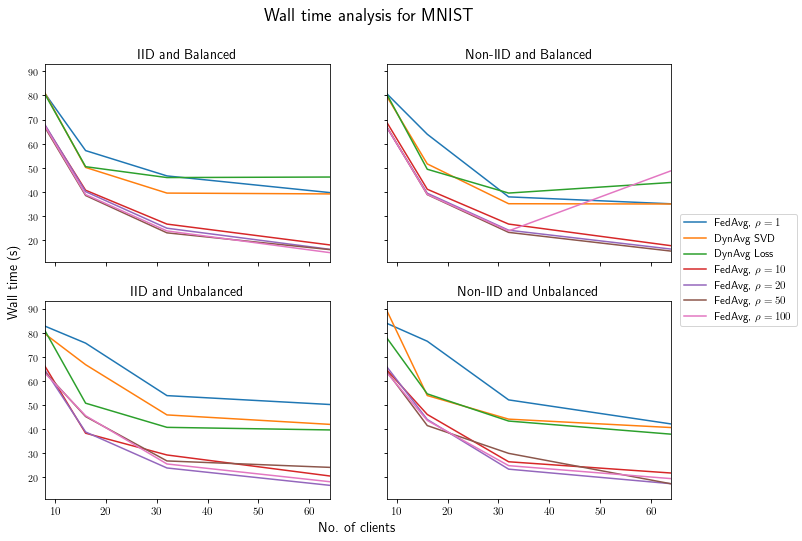

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# IID and Balanced
t_ib_merged.plot(ax=axes[0, 0])
# axes[0, 0].set_ylabel('Wall time (s)', fontdict=dict(fontsize=12))
axes[0, 0].set_title('IID and Balanced', fontdict=dict(fontsize=14))
axes[0, 0].legend().remove()

# Non IID and Balanced
t_nb_merged.plot(ax=axes[0, 1])
axes[0, 1].set_title('Non-IID and Balanced', fontdict=dict(fontsize=14))
axes[0, 1].legend().remove()

# IID and Unbalanced
t_iu_merged.plot(ax=axes[1, 0])
axes[1, 0].set_title('IID and Unbalanced', fontdict=dict(fontsize=14))
axes[1, 0].set_xlabel('')
axes[1, 0].legend().remove()

# Non IID and Unbalanced
t_nu_merged.plot(ax=axes[1, 1])
axes[1, 1].set_title('Non-IID and Unbalanced', fontdict=dict(fontsize=14))
axes[1, 1].set_xlabel('')

handles, labels = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend().remove()
# fig.legend(handles, labels, loc='upper right', fontsize=12)
fig.legend(handles, labels, loc=7, fontsize=11)
# fig2.tight_layout()
fig.subplots_adjust(right=0.85)

plt.setp(axes[1, 0].get_xticklabels(), fontsize=11)
plt.setp(axes[1, 1].get_xticklabels(), fontsize=11)
plt.setp(axes[0, 1].get_yticklabels(), fontsize=11)
plt.setp(axes[1, 1].get_yticklabels(), fontsize=11)
plt.ylabel('Wall time (s)', fontdict=dict(fontsize=14))
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.suptitle('Wall time analysis for MNIST', fontsize=18)
plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')

### Accuracy analysis

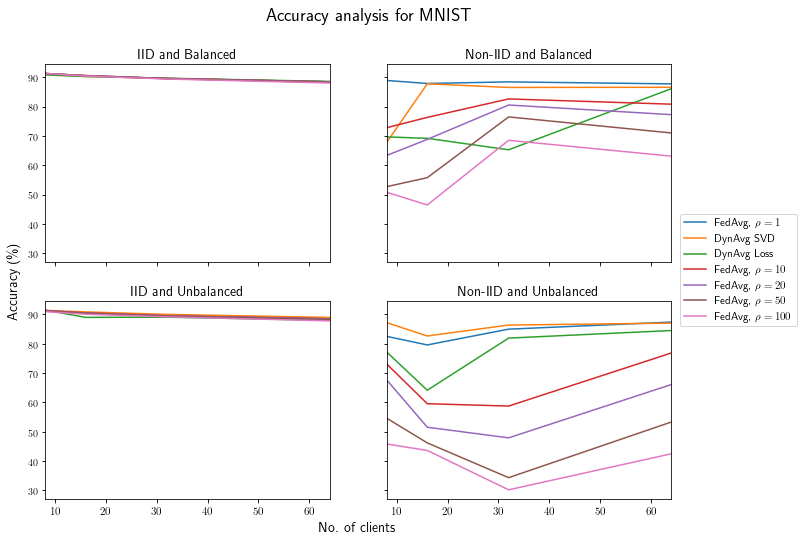

In [22]:
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
# add a big axes, hide frame
fig2.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# IID and balanced
acc_ib_merged.plot(ax=axes2[0, 0])
axes2[0, 0].set_title('IID and Balanced', fontdict=dict(fontsize=14))
axes2[0, 0].legend().remove()

# Non-IID and balanced
acc_nb_merged.plot(ax=axes2[0, 1])
axes2[0, 1].set_title('Non-IID and Balanced', fontdict=dict(fontsize=14))
axes2[0, 1].legend().remove()

# IID and Unbalanced
acc_iu_merged.plot(ax=axes2[1, 0])
axes2[1, 0].set_title('IID and Unbalanced', fontdict=dict(fontsize=14))
axes2[1, 0].set_xlabel('')
axes2[1, 0].legend().remove()

# Non-IID and Unbalanced
acc_nu_merged.plot(ax=axes2[1, 1])
axes2[1, 1].set_title('Non-IID and Unbalanced', fontdict=dict(fontsize=14))
axes2[1, 1].set_xlabel('')

handles, labels = axes2[1, 1].get_legend_handles_labels()
axes2[1, 1].legend().remove()
# fig2.legend(handles, labels, loc='upper right', fontsize=12, bbox_to_anchor=(0.95, 0.83), borderaxespad=0)
fig2.legend(handles, labels, loc=7, fontsize=11)
# fig2.tight_layout()
fig2.subplots_adjust(right=0.85)
plt.setp(axes2[1, 0].get_xticklabels(), fontsize=11)
plt.setp(axes2[1, 1].get_xticklabels(), fontsize=11)
plt.setp(axes2[0, 1].get_yticklabels(), fontsize=11)
plt.setp(axes2[1, 1].get_yticklabels(), fontsize=11)
plt.ylabel('Accuracy (\%)', fontdict=dict(fontsize=14))
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.suptitle(r'Accuracy analysis for MNIST', fontsize=18)
plt.savefig('../reports/figures/accuracy-analysis.png', dpi=500, format='png')

### Fashion-MNIST

In [23]:
f_mnist_fed = pd.read_csv("../data/output/fmnist-pkt-size.csv")
# mnist_avg = pd.read_csv("../data/output/mnist-avg.csv")
f_mnist_fed = f_mnist_fed.loc[~f_mnist_fed.isnull().any(axis=1)]

In [24]:
f_mnist_fed.head()

,N_WORKERS,COMM_PERIOD,AGG_MODE,COMM_MODE,NONIID,UNBALANCED,TIME,ACCURACY,PKT_SIZE
0,16,1,0,0,0,0,60.652477,82.33,44.968
1,16,1,0,0,0,1,72.326389,82.36,44.968
2,16,1,0,0,1,0,61.542717,77.62,44.968
3,16,1,0,0,1,1,56.026156,64.18,44.968
4,16,1,0,1,0,0,54.166555,82.18,23.353


In [25]:
# mnist_avg.head()

#### IID and balanced

##### Time

In [26]:
ib_query = 'NONIID == 0 and UNBALANCED == 0'
t_ib_merged_f = performance_pivot(f_mnist_fed, ib_query, 'TIME', columns=columns, xlabel=xlabel)
t_ib_merged_f

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,81.111124,81.325586,81.135974,67.744885,67.732052,66.954560,66.059596
16,53.082782,51.162418,51.295309,40.937495,40.297121,39.178140,38.356057
32,38.489606,41.562262,39.060068,26.693646,23.979646,23.163294,22.724875
64,38.222111,33.519644,39.421713,17.865979,16.344227,15.514344,17.175292


##### Accuracy

In [27]:
acc_ib_merged_f = performance_pivot(f_mnist_fed, ib_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_ib_merged_f

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,83.30,83.11,83.04,83.30,83.28,83.26,83.20
16,82.33,82.11,81.98,82.32,82.30,82.26,82.27
32,80.95,80.69,80.72,80.94,80.93,80.89,80.87
64,79.16,78.85,79.20,79.15,79.12,79.10,78.73


#### Non-IID and Balanced

In [28]:
nb_query = 'NONIID == 1 and UNBALANCED == 0'

###### Time

In [29]:
t_nb_merged_f = performance_pivot(f_mnist_fed, nb_query, 'TIME', columns=columns, xlabel=xlabel)
t_nb_merged_f

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,81.112233,79.875899,81.935009,67.134549,66.715260,67.540859,66.455516
16,59.055749,51.455582,52.290528,40.042556,39.036174,39.271614,39.052783
32,37.639466,38.846707,42.370467,28.090327,25.139071,24.147564,23.042122
64,38.670038,34.159706,30.910865,17.650809,16.129778,15.280797,31.779874


##### Accuracy

In [30]:
acc_nb_merged_f = performance_pivot(f_mnist_fed, nb_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_nb_merged_f

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,72.88,60.87,33.82,52.75,48.48,45.95,43.15
16,77.62,68.29,46.05,57.51,46.48,37.38,32.99
32,77.67,72.11,54.55,58.86,47.47,38.02,32.90
64,76.69,68.18,63.57,54.67,42.21,30.52,26.53


#### Non-IID and Unbalanced

##### Time

In [31]:
nu_query = 'NONIID == 1 and UNBALANCED == 1'

In [32]:
t_nu_merged_f = performance_pivot(f_mnist_fed, nu_query, 'TIME', columns=columns, xlabel=xlabel)
t_nu_merged_f

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,83.298596,81.037678,79.068699,65.759144,64.786448,63.758009,63.779532
16,55.599540,59.154113,57.925528,42.078619,35.859849,41.832592,37.741383
32,50.707368,41.032156,36.464281,37.935009,25.403876,24.520103,27.901138
64,48.709202,34.585355,35.828036,19.040363,22.345302,18.181818,17.731668


##### Accuracy

In [33]:
acc_nu_merged_f = performance_pivot(f_mnist_fed, nu_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_nu_merged_f

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,67.79,69.35,43.86,55.08,44.81,29.61,25.06
16,64.18,64.42,50.12,43.82,39.73,26.24,23.00
32,64.35,61.19,59.24,40.33,35.16,30.67,22.30
64,71.52,67.88,61.96,40.60,30.03,19.92,19.75


#### IID and Unbalanced

##### Time

In [34]:
iu_query = 'NONIID == 0 and UNBALANCED == 1'

In [35]:
t_iu_merged_f = performance_pivot(f_mnist_fed, iu_query, 'TIME', columns=columns, xlabel=xlabel)
t_iu_merged_f

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,84.121199,78.973186,79.630816,65.448938,65.103688,63.690424,63.281691
16,74.097981,64.204691,52.238587,37.839352,46.045176,46.720171,42.392884
32,59.431855,46.946655,42.179990,27.506687,26.478805,27.596854,25.413807
64,49.497367,42.190504,41.841849,18.981853,16.253321,19.169949,16.559473


##### Accuracy

In [36]:
acc_iu_merged_f = performance_pivot(f_mnist_fed, iu_query, 'ACCURACY', columns=columns, xlabel=xlabel)
acc_iu_merged_f

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
No. of clients,,,,,,,
8,83.31,83.41,83.60,83.28,83.21,83.11,83.03
16,82.36,82.84,81.08,82.38,82.29,82.11,81.79
32,80.95,81.67,80.58,80.96,80.94,80.80,80.32
64,79.37,80.44,78.65,79.29,79.20,78.99,78.47


#### Packet size

In [44]:
pkt_size_piv_f = (
    f_mnist_fed.query("AGG_MODE == 1")
    .pivot_table(
        values="PKT_SIZE", index="N_WORKERS", columns=["COMM_MODE", "COMM_PERIOD"]
    )
)
pkt_size_piv_f.columns = [
    r'FedAvg, $\rho=1$', r'FedAvg, $\rho=10$', r'FedAvg, $\rho=20$',
    r'FedAvg, $\rho=50$', r'FedAvg, $\rho=100$', r'DynAvg SVD', r'DynAvg Loss'
]
pkt_size_piv_f = pkt_size_piv_f.loc[:, columns]
pkt_size_piv_f.index = pkt_size_piv_f.index - 1

In [45]:
pkt_size_piv_f

,"FedAvg, $\rho=1$",DynAvg SVD,DynAvg Loss,"FedAvg, $\rho=10$","FedAvg, $\rho=20$","FedAvg, $\rho=50$","FedAvg, $\rho=100$"
N_WORKERS,,,,,,,
7,20.985,12.62100,3.83700,2.099,1.049,0.420,0.210
15,44.968,24.91225,5.56400,4.497,2.248,0.899,0.450
31,92.934,48.32575,9.73575,9.293,4.647,1.859,0.929
63,188.866,94.47800,23.33825,18.887,9.443,3.777,1.889


### Wall time analysis

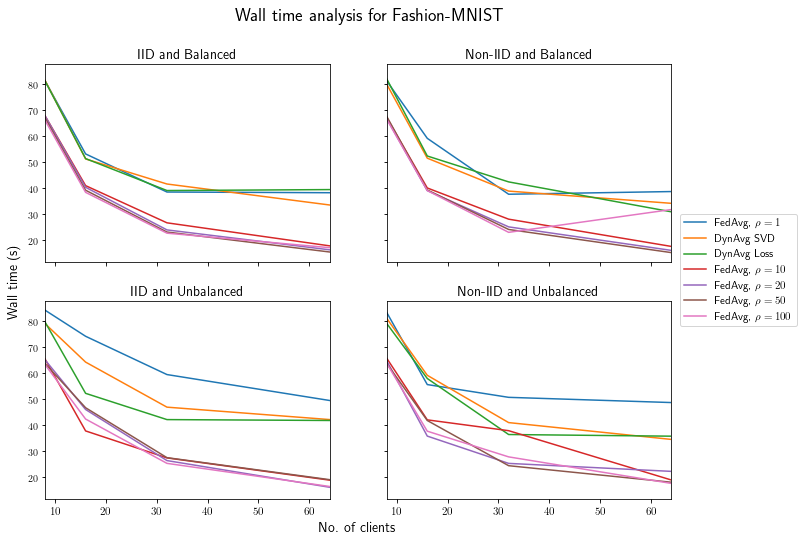

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# IID and Balanced
t_ib_merged_f.plot(ax=axes[0, 0])
axes[0, 0].set_title('IID and Balanced', fontdict=dict(fontsize=14))
axes[0, 0].legend().remove()

# Non IID and Balanced
t_nb_merged_f.plot(ax=axes[0, 1])
axes[0, 1].set_title('Non-IID and Balanced', fontdict=dict(fontsize=14))
axes[0, 1].legend().remove()

# IID and Unbalanced
t_iu_merged_f.plot(ax=axes[1, 0])
axes[1, 0].set_title('IID and Unbalanced', fontdict=dict(fontsize=14))
axes[1, 0].set_xlabel('')
axes[1, 0].legend().remove()

# Non IID and Unbalanced
t_nu_merged_f.plot(ax=axes[1, 1])
axes[1, 1].set_title('Non-IID and Unbalanced', fontdict=dict(fontsize=14))
axes[1, 1].set_xlabel('')

handles, labels = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend().remove()
# fig.legend(handles, labels, loc='upper right', fontsize=12)
fig.legend(handles, labels, loc=7, fontsize=11)
# fig2.tight_layout()
fig.subplots_adjust(right=0.85)

plt.setp(axes[1, 0].get_xticklabels(), fontsize=11)
plt.setp(axes[1, 1].get_xticklabels(), fontsize=11)
plt.setp(axes[0, 1].get_yticklabels(), fontsize=11)
plt.setp(axes[1, 1].get_yticklabels(), fontsize=11)
plt.ylabel('Wall time (s)', fontdict=dict(fontsize=14))
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.suptitle('Wall time analysis for Fashion-MNIST', fontsize=18)
plt.savefig('../reports/figures/time-analysis-fmnist.png', dpi=500, format='png')

### Accuracy analysis

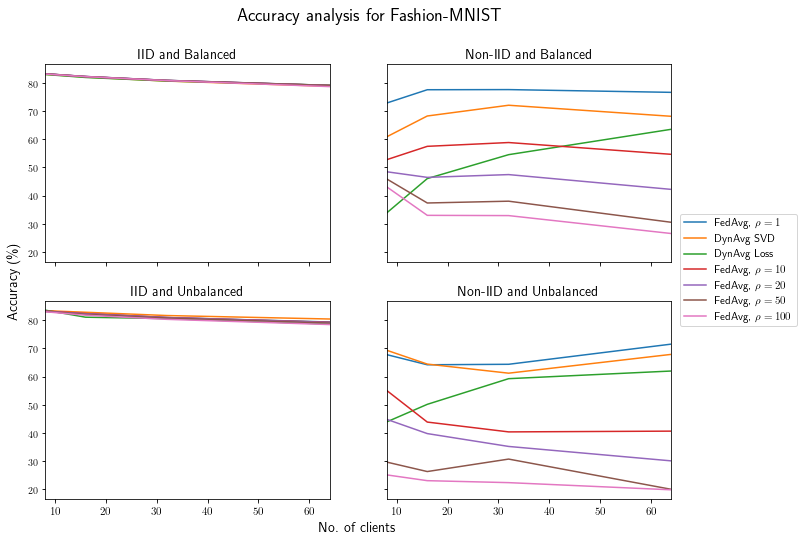

In [40]:
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
# add a big axes, hide frame
fig2.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# IID and balanced
acc_ib_merged_f.plot(ax=axes2[0, 0])
axes2[0, 0].set_title('IID and Balanced', fontdict=dict(fontsize=14))
axes2[0, 0].legend().remove()

# Non-IID and balanced
acc_nb_merged_f.plot(ax=axes2[0, 1])
axes2[0, 1].set_title('Non-IID and Balanced', fontdict=dict(fontsize=14))
axes2[0, 1].legend().remove()

# IID and Unbalanced
acc_iu_merged_f.plot(ax=axes2[1, 0])
axes2[1, 0].set_title('IID and Unbalanced', fontdict=dict(fontsize=14))
axes2[1, 0].set_xlabel('')
axes2[1, 0].legend().remove()

# Non-IID and Unbalanced
acc_nu_merged_f.plot(ax=axes2[1, 1])
axes2[1, 1].set_title('Non-IID and Unbalanced', fontdict=dict(fontsize=14))
axes2[1, 1].set_xlabel('')
# axes2[1, 1].legend('')

handles, labels = axes2[1, 1].get_legend_handles_labels()
axes2[1, 1].legend().remove()
# fig2.legend(handles, labels, loc='upper right', fontsize=12)
fig2.legend(handles, labels, loc=7, fontsize=11)
# fig2.tight_layout()
fig2.subplots_adjust(right=0.85)

plt.setp(axes2[1, 0].get_xticklabels(), fontsize=11)
plt.setp(axes2[1, 1].get_xticklabels(), fontsize=11)
plt.setp(axes2[0, 1].get_yticklabels(), fontsize=11)
plt.setp(axes2[1, 1].get_yticklabels(), fontsize=11)
plt.ylabel('Accuracy (\%)', fontdict=dict(fontsize=14))
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.suptitle(r'Accuracy analysis for Fashion-MNIST', fontsize=18)
plt.savefig('../reports/figures/accuracy-analysis-fashion-mnist.png', dpi=500, format='png')

### Packet size analysis

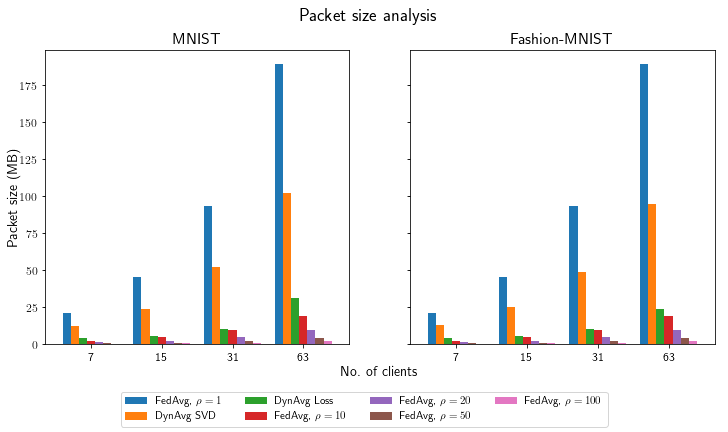

In [48]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Mnist
pkt_size_piv.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('MNIST', fontdict=dict(fontsize=16))
axes[0].set_xlabel('')
axes[0].legend().remove()
# Fashion Mnist
pkt_size_piv_f.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Fashion-MNIST', fontdict=dict(fontsize=16))
axes[1].set_xlabel('')
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend().remove()
# fig.legend(handles, labels, loc='upper right', prop={'size': 12})
fig.legend(handles, labels, loc='lower center', fontsize=11, ncol=4)
# fig2.tight_layout()
fig.subplots_adjust(bottom=0.2)


plt.suptitle('Packet size analysis', fontsize=18)
plt.xlabel('No. of clients', fontdict=dict(fontsize=14))
plt.ylabel('Packet size (MB)', fontdict=dict(fontsize=14))
plt.setp(axes[0].get_xticklabels(), ha='center', rotation=0, fontsize=12)
plt.setp(axes[1].get_xticklabels(), ha='center', rotation=0, fontsize=12)
plt.setp(axes[0].get_yticklabels(), fontsize=12)
plt.setp(axes[1].get_yticklabels(), fontsize=12)
plt.savefig('../reports/figures/packet-size-analysis.png', dpi=500, format='png')